In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.special import expit as logistic

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.26.1


In [5]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [6]:
N = 100

true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

outcome = rng.normal(loc=true_mu, scale=true_sd, size=N)

f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"

'1.59, 5.69, 4.97, 17.54'

In [7]:
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

f"{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"

'0.00, 1.00, -0.00, 1.00'

In [8]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


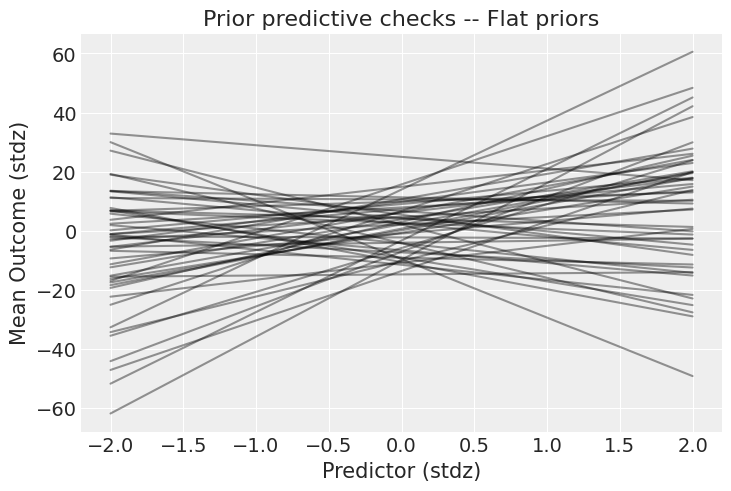

In [9]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

In [10]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


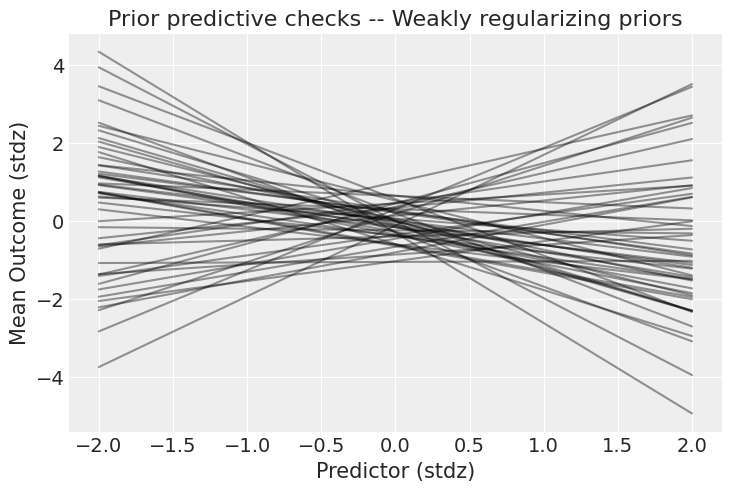

In [11]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


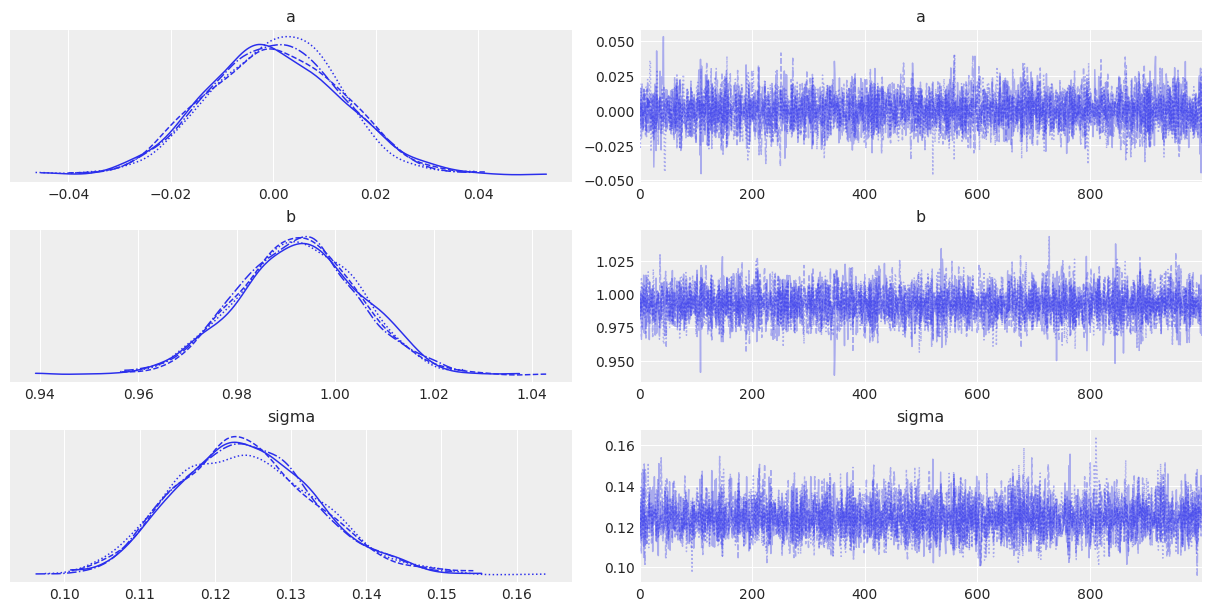

In [12]:
with model_1:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

az.plot_trace(idata);

In [13]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [obs]


Output()

In [14]:
idata.posterior_predictive

<xarray.Dataset> Size: 3MB
Dimensions:    (chain: 4, draw: 1000, obs_dim_0: 100)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_dim_0  (obs_dim_0) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_0) float64 3MB -0.3941 -0.003109 ... 0.7515
Attributes:
    created_at:                 2025-11-13T16:30:54.293266+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1

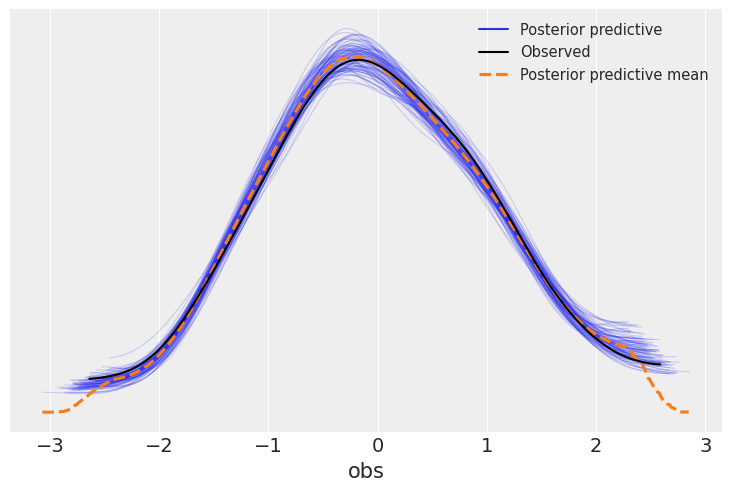

In [15]:
az.plot_ppc(idata, num_pp_samples=100);

In [16]:
post = idata.posterior
mu_pp = post["a"] + post["b"] * xr.DataArray(predictor_scaled, dims=["obs_id"])

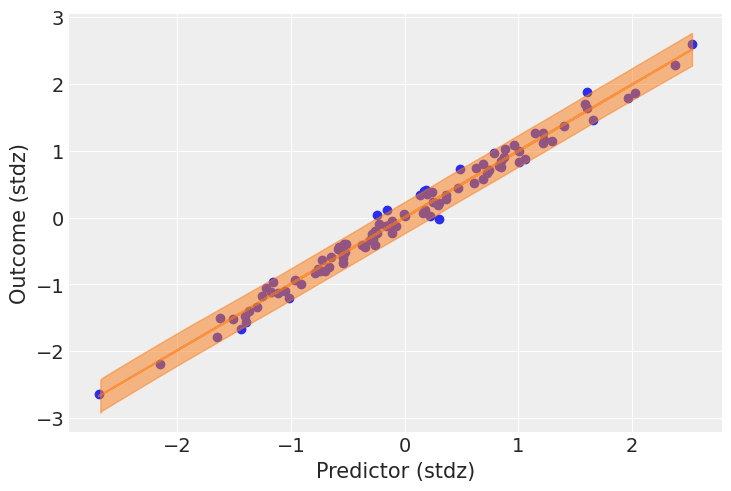

In [17]:
_, ax = plt.subplots()

ax.plot(
    predictor_scaled, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(predictor_scaled, idata.observed_data["obs"])
az.plot_hdi(predictor_scaled, idata.posterior_predictive["obs"])

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");

In [18]:
N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = rng.binomial(1, true_p)
outcomes[:10]

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1])

In [22]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.Data("pred", predictors, dims="obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)
az.summary(idata_2, var_names=["betas"], round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.22,0.11,0.03,0.43,0.0,0.0,4002.84,2883.06,1.0
betas[1],1.02,0.14,0.77,1.29,0.0,0.0,4079.89,2670.03,1.0


In [23]:
predictors_out_of_sample = rng.normal(size=50)
outcomes_out_of_sample = rng.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

Sampling: []


Output()

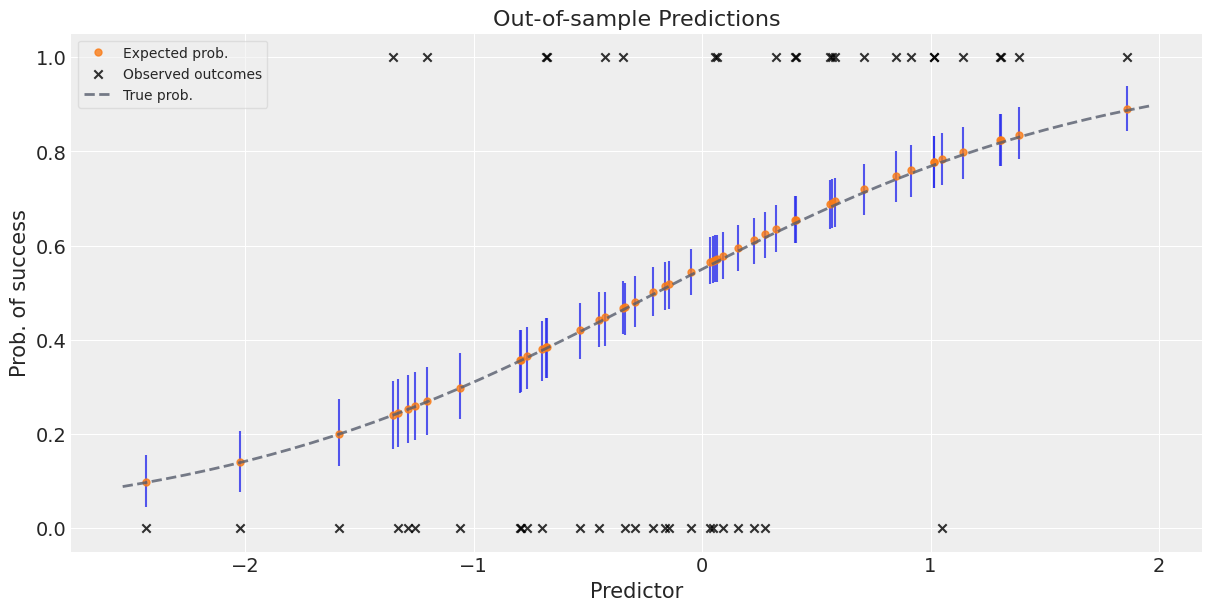

In [24]:
_, ax = plt.subplots(figsize=(12, 6))

preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms=5,
    color="C1",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)
# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);